# **CSEL 301: Final**
Submitted by: Vanesse V. Reyes and Seanrei Ethan Valdeabella


**Project Title: Exploring Pizza Sales Data**


This code mostly tackle and Show all the data that's inside the '11_Pizza-Sales-Analysis.csv'

In [ ]:
#@title Importing Libraries
!pip install shap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import requests
import shap



warnings.simplefilter(action='ignore')


# **Note: RE RUN ALL THE CELL TO AVOID ERROR AND DONT FORGET TO ADD THE DATA SET '11_Pizza-Sales-Analysis.csv' and install '!pip install shap'**

In [ ]:
#@title DataSet Loading


data = pd.read_csv('11_Pizza-Sales-Analysis.csv')



In [ ]:
#@title Data Overview
print("Datasets:")
print(data.describe())

Datasets:
       order_details_id      order_id      quantity    unit_price  \
count      48620.000000  48620.000000  48620.000000  48620.000000   
mean       24310.500000  10701.479761      1.019622     16.494132   
std        14035.529381   6180.119770      0.143077      3.621789   
min            1.000000      1.000000      1.000000      9.750000   
25%        12155.750000   5337.000000      1.000000     12.750000   
50%        24310.500000  10682.500000      1.000000     16.500000   
75%        36465.250000  16100.000000      1.000000     20.250000   
max        48620.000000  21350.000000      4.000000     35.950000   

        total_price  
count  48620.000000  
mean      16.821474  
std        4.437398  
min        9.750000  
25%       12.750000  
50%       16.500000  
75%       20.500000  
max       83.000000  


In [ ]:
#@title Duplicated Data Checking
print("\nDuplicate rows indicator:")
print(data[data.duplicated()])


Duplicate rows indicator:
Empty DataFrame
Columns: [order_details_id, order_id, pizza_id, quantity, order_date, order_time, unit_price, total_price, pizza_size, pizza_category, pizza_ingredients, pizza_name]
Index: []


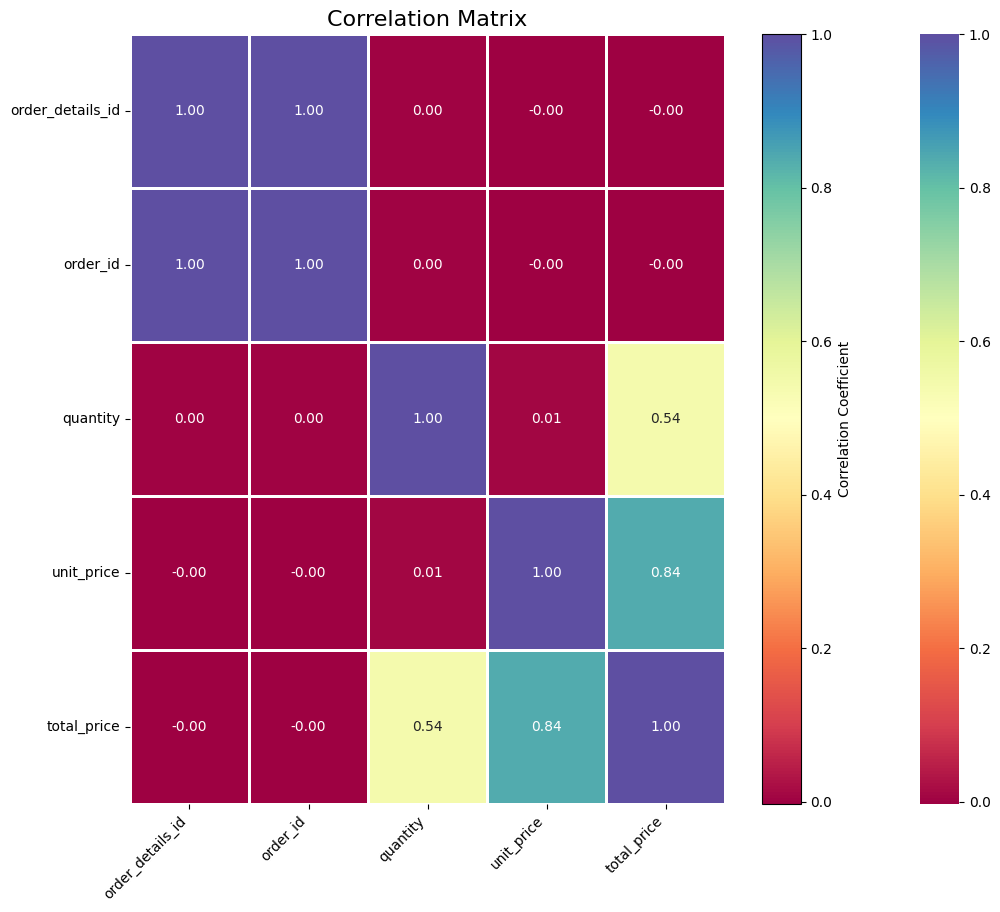

In [ ]:
#title Correlation Matrix

numeric_data = data.select_dtypes(include=['int64', 'float64'])


corr_matrix = numeric_data.corr()


plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix,
                      annot=True,
                      annot_kws={"size": 10},
                      cmap='Spectral',
                      fmt='.2f',
                      linewidths=1,
                      linecolor='white')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)
plt.title('Correlation Matrix', fontsize=16)
plt.colorbar(heatmap.collections[0]).set_label('Correlation Coefficient')
plt.show()

Index(['order_details_id', 'order_id', 'pizza_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')


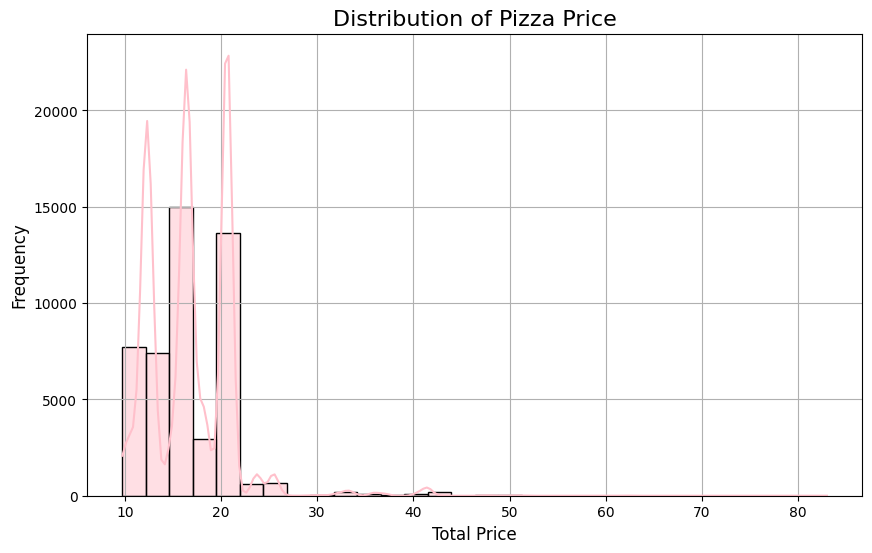

In [ ]:
#@title Distribution Of Total Pizza Price
print(data.columns)


plt.figure(figsize=(10, 6))
sns.histplot(data['total_price'].dropna(), bins=30, kde=True, color='pink', edgecolor='black')
plt.title('Distribution of Pizza Price', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

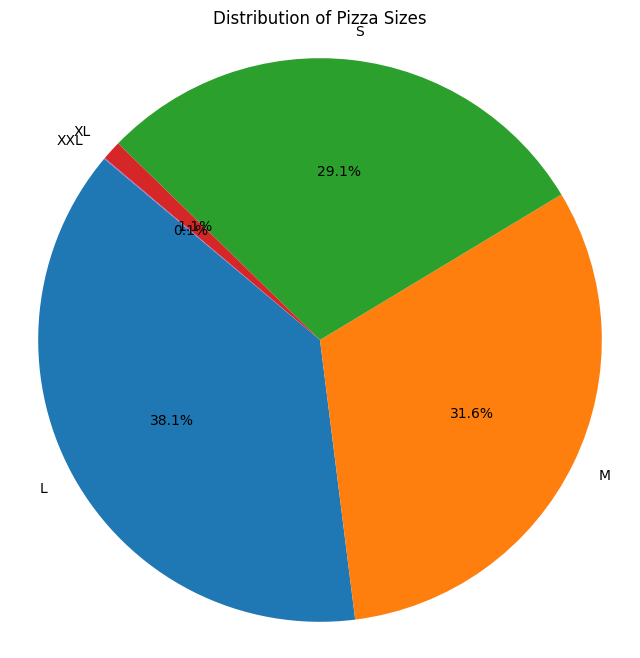

In [ ]:
#@title Pizza Sales

plt.figure(figsize=(8, 8))
sizes = data['pizza_size'].value_counts()
plt.pie(sizes, labels=sizes.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Pizza Sizes')
plt.axis('equal')
plt.show()

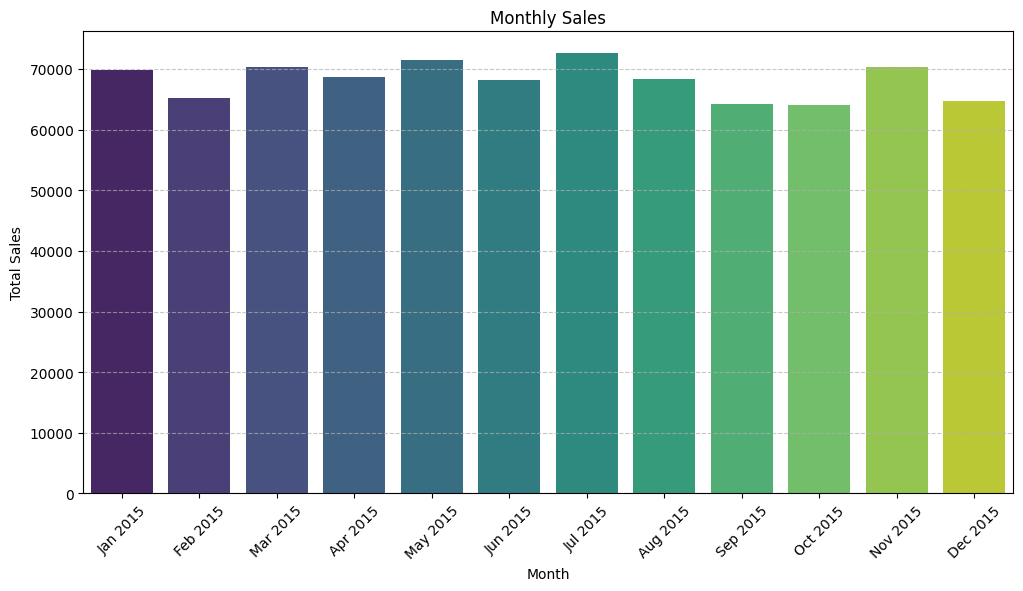

In [ ]:
#@title Monthly Sales

data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce', format='%m/%d/%Y')
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce', dayfirst=True)


data.dropna(subset=['order_date'], inplace=True)

data.set_index('order_date', inplace=True)

monthly_sales = data.resample('M')['total_price'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_sales['order_date'].dt.strftime('%b %Y'), y=monthly_sales['total_price'], palette='viridis')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


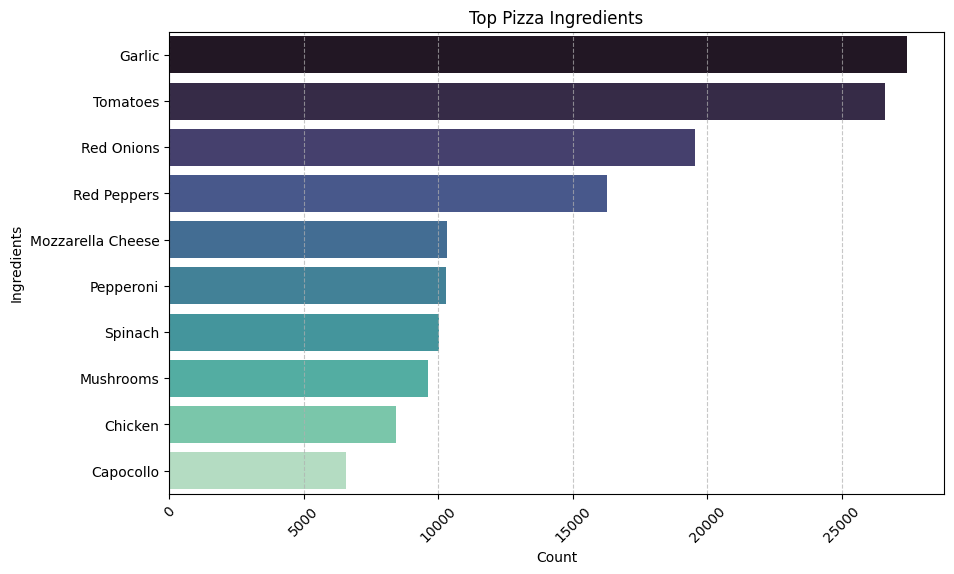

In [ ]:
top_ingredients = data['pizza_ingredients'].str.split(',').explode().str.strip().value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette='mako')
plt.title('Top Pizza Ingredients')
plt.xlabel('Count')
plt.ylabel('Ingredients')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

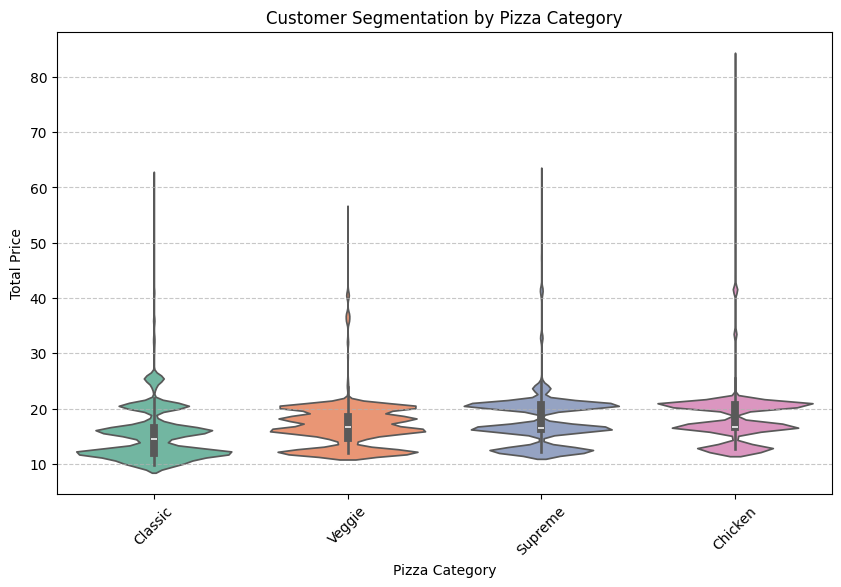

In [ ]:
#@title Pizza Category

plt.figure(figsize=(10, 6))
sns.violinplot(x='pizza_category', y='total_price', data=data, palette='Set2')
plt.title('Customer Segmentation by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Total Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Liner Regression Model**

In [ ]:
#@title Data Preperation
data_linear = data.dropna(subset=['total_price']).reset_index(drop=True)
le = LabelEncoder()
data_linear['pizza_size_encoded'] = le.fit_transform(data_linear['pizza_size'])


In [ ]:
#@title Feature Engineering
features = ['pizza_size_encoded']
X = data_linear[features]
y = data_linear['total_price']


In [ ]:
#@title Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
#@title Text train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#@title Model Training
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
#@title Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 12.46679613764995
R^2 Score: 0.37705110491080573


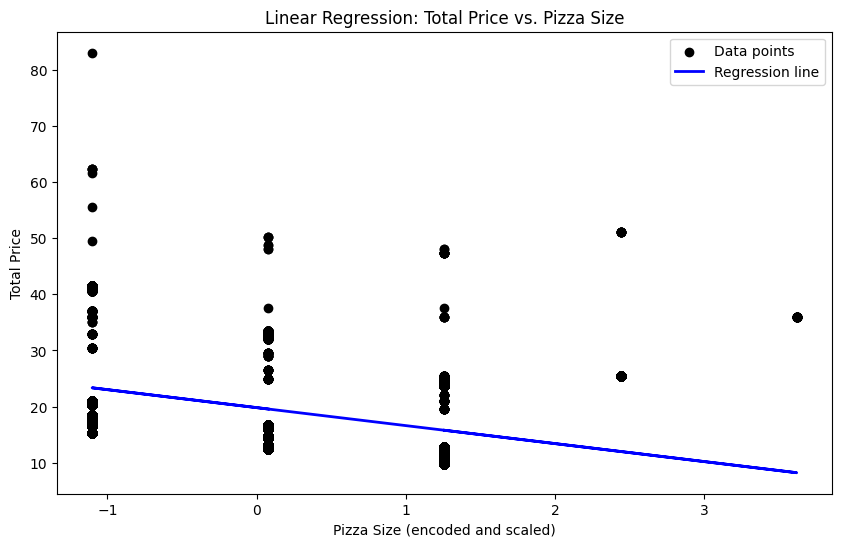

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled, y, color='black', label='Data points')
plt.plot(X_scaled, model.predict(X_scaled), color='blue', linewidth=2, label='Regression line')
plt.xlabel('Pizza Size (encoded and scaled)')
plt.ylabel('Total Price')
plt.title('Linear Regression: Total Price vs. Pizza Size')
plt.legend()
plt.show()


# **Logistic Regression**

In [ ]:
#@title Data Preperation
data_logistic = data.dropna(subset=['pizza_ingredients']).reset_index(drop=True)
le = LabelEncoder()
data_logistic['pizza_category_encoded'] = le.fit_transform(data_logistic['pizza_category'])

In [ ]:
#@title Select Features and Data Variable
if 'total_price' in data_logistic.columns:
    data_logistic['high_price'] = (data_logistic['total_price'] > data_logistic['total_price'].median()).astype(int)
    features = ['pizza_category_encoded']
    X = data_logistic[features]
    y = data_logistic['high_price']
else:
    raise ValueErrorr("Column 'total_price' is not available in the DataFrame or not suitable for binary classification.")

In [ ]:
#@title Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#@title Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
#@title Model Training

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]

In [ ]:
#@title Model Evaluation

y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.6681406828465652
Confusion Matrix:
[[4775  433]
 [2794 1722]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      5208
           1       0.80      0.38      0.52      4516

    accuracy                           0.67      9724
   macro avg       0.71      0.65      0.63      9724
weighted avg       0.71      0.67      0.64      9724



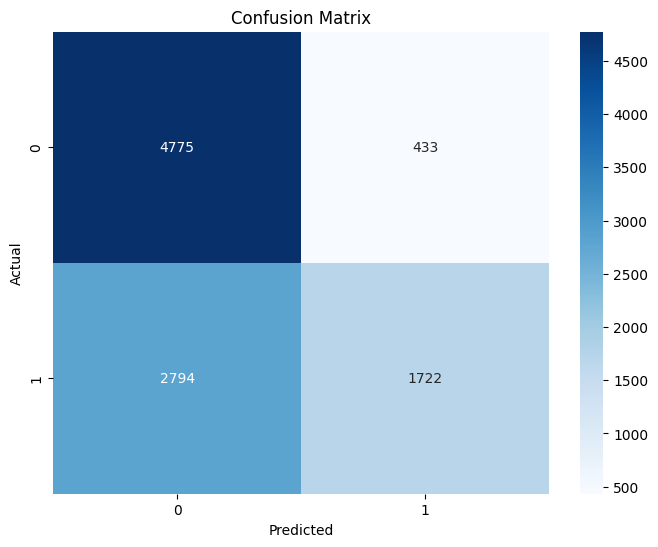

In [ ]:
#@title Confusion Matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.6681406828465652
Confusion Matrix:
[[4775  433]
 [2794 1722]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      5208
           1       0.80      0.38      0.52      4516

    accuracy                           0.67      9724
   macro avg       0.71      0.65      0.63      9724
weighted avg       0.71      0.67      0.64      9724

ROC AUC: 0.5651097684423636


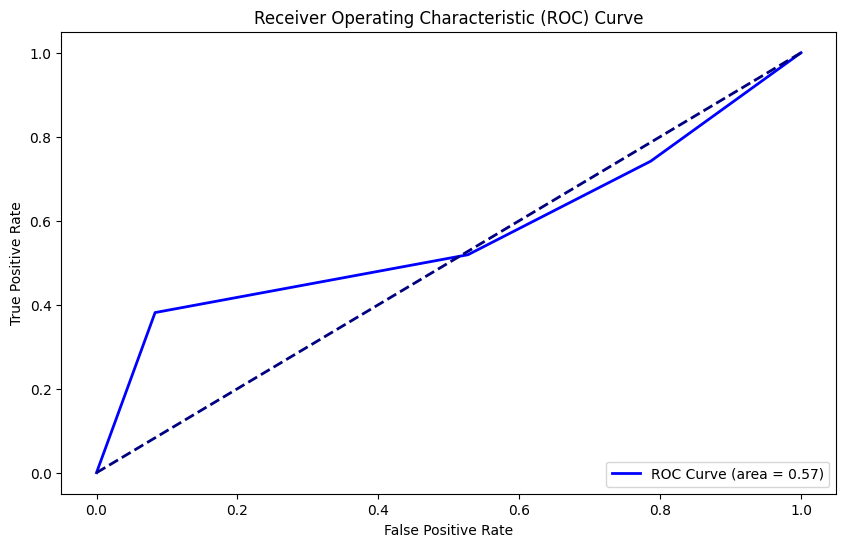

In [ ]:
#@title ROC curve and AUC on text Data

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {auc}')

# Plotting the ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **For Data Visualization**

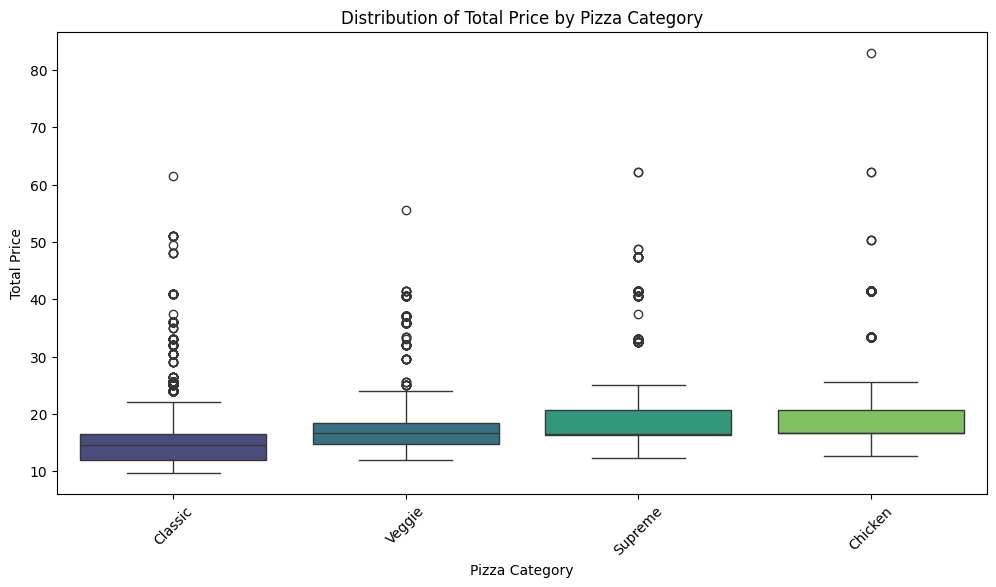

In [ ]:
#@title Distrubution of  Pizza Categories

plt.figure(figsize=(12, 6))
sns.boxplot(x='pizza_category', y='total_price', data=data, palette='viridis')
plt.title('Distribution of Total Price by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Total Price')
plt.xticks(rotation=45)
plt.show()

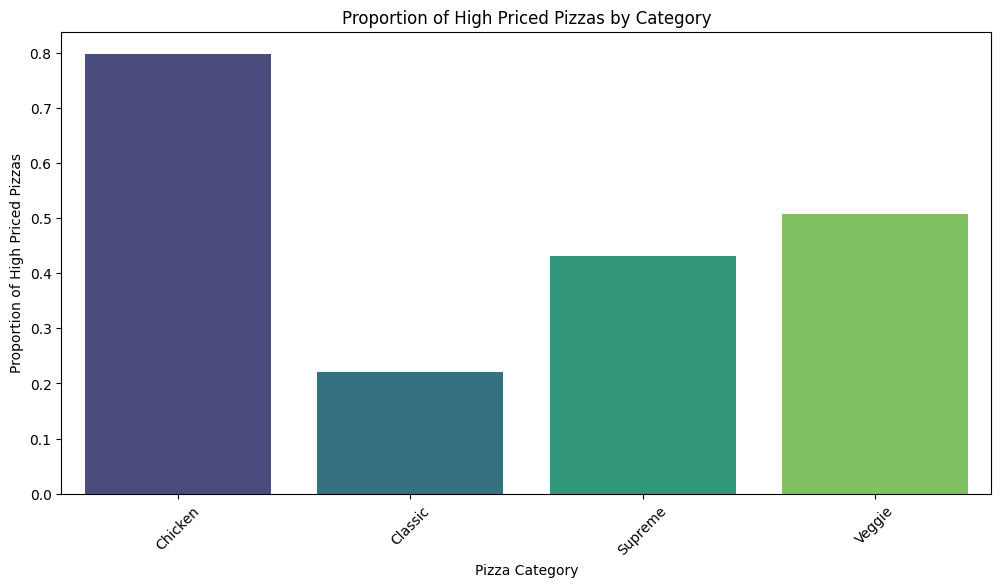

In [ ]:
#@title High Priced Pizza by Category
data_logistic['high_price'] = (data_logistic['total_price'] > data_logistic['total_price'].median()).astype(int)
category_high_price = data_logistic.groupby('pizza_category')['high_price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='pizza_category', y='high_price', data=category_high_price, palette='viridis')
plt.xlabel('Pizza Category')
plt.ylabel('Proportion of High Priced Pizzas')
plt.title('Proportion of High Priced Pizzas by Category')
plt.xticks(rotation=45)
plt.show()

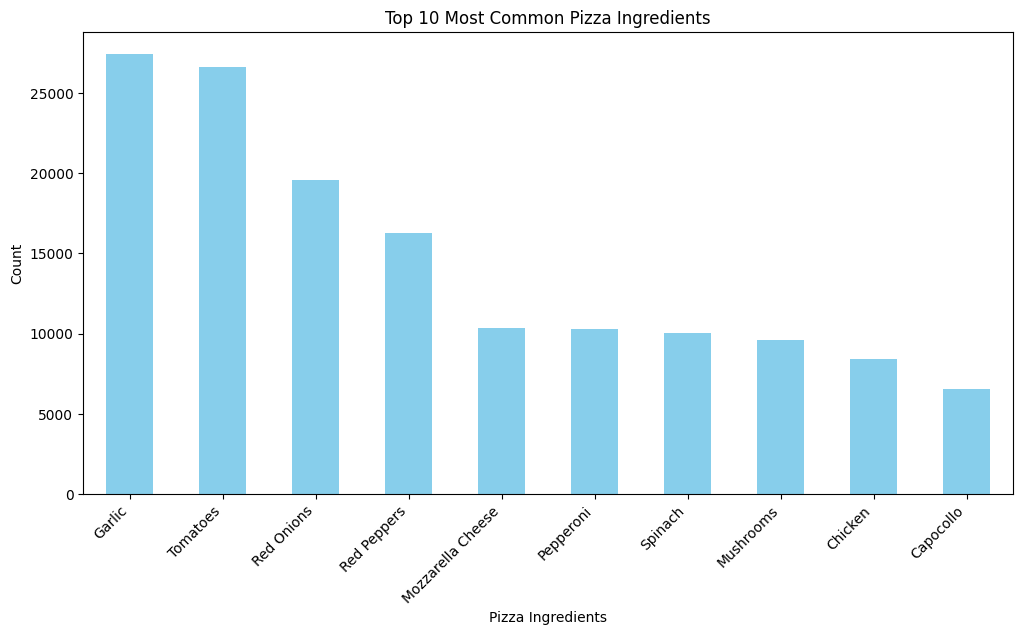

In [ ]:
#@title Top 10 most Common Pizza Ingredients


ingredient_counts = data['pizza_ingredients'].str.split(',').explode().str.strip().value_counts()


top_n = 10
top_ingredients = ingredient_counts.head(top_n)

plt.figure(figsize=(12, 6))
top_ingredients.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Most Common Pizza Ingredients')
plt.xlabel('Pizza Ingredients')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
print(data.head())
print(data.columns)

data['order_time'] = pd.to_datetime(data['order_time'], errors='coerce')

# Drop rows with missing values in critical columns
data = data.dropna(subset=['total_price', 'order_time', 'pizza_size', 'pizza_category'])

# Encode categorical variables
data['pizza_size_encoded'] = pd.factorize(data['pizza_size'])[0]
data['pizza_category_encoded'] = pd.factorize(data['pizza_category'])[0]

X = data[['pizza_size_encoded', 'pizza_category_encoded']]
y = data['total_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection and evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[model_name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
print(results_df)

# Cross-validation
cv_results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_results[model_name] = cv_scores.mean()

cv_results_df = pd.DataFrame(cv_results, index=['CV R2']).T
print(cv_results_df)

            order_details_id  order_id       pizza_id  quantity order_time  \
order_date                                                                   
2015-01-01                 1         1     hawaiian_m         1   11:38:36   
2015-01-01                 2         2  classic_dlx_m         1   11:57:40   
2015-01-01                 3         2  five_cheese_l         1   11:57:40   
2015-01-01                 4         2    ital_supr_l         1   11:57:40   
2015-01-01                 5         2     mexicana_m         1   11:57:40   

            unit_price  total_price pizza_size pizza_category  \
order_date                                                      
2015-01-01       13.25        13.25          M        Classic   
2015-01-01       16.00        16.00          M        Classic   
2015-01-01       18.50        18.50          L         Veggie   
2015-01-01       20.75        20.75          L        Supreme   
2015-01-01       16.00        16.00          M         Veggie  

# **Advance Data Analysis**

In [ ]:
#@title Hyperparameter tuning
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
print(f'Best parameters: {random_search.best_params_}')

# Evaluate the best model
y_pred_best = best_rf.predict(X_test)
print('Best Random Forest Regressor performance:')
print(f'MAE: {mean_absolute_error(y_test, y_pred_best)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_best)}')
print(f'R2: {r2_score(y_test, y_pred_best)}')

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}
Best Random Forest Regressor performance:
MAE: 1.1985799844397031
MSE: 8.005486363731421
R2: 0.5999767037276528


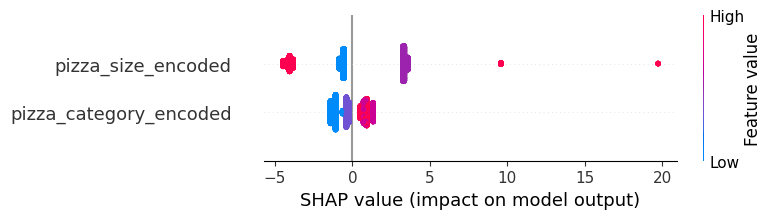

In [ ]:
#@title Model Interpretation
# SHAP values for the best model
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, feature_names=X.columns)

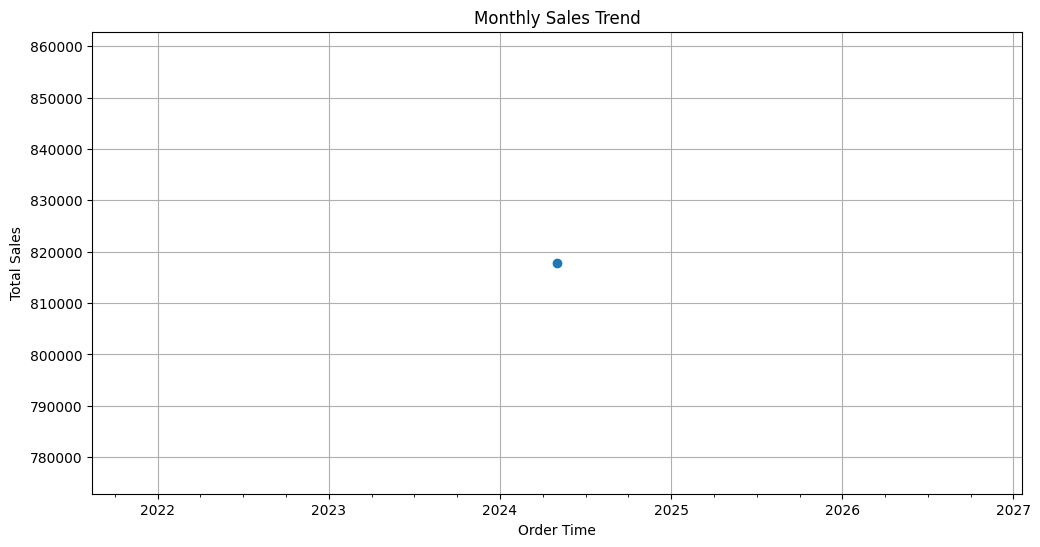

In [ ]:
#@title Monthly sales trend
monthly_sales = data.resample('M', on='order_time')['total_price'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Order Time')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

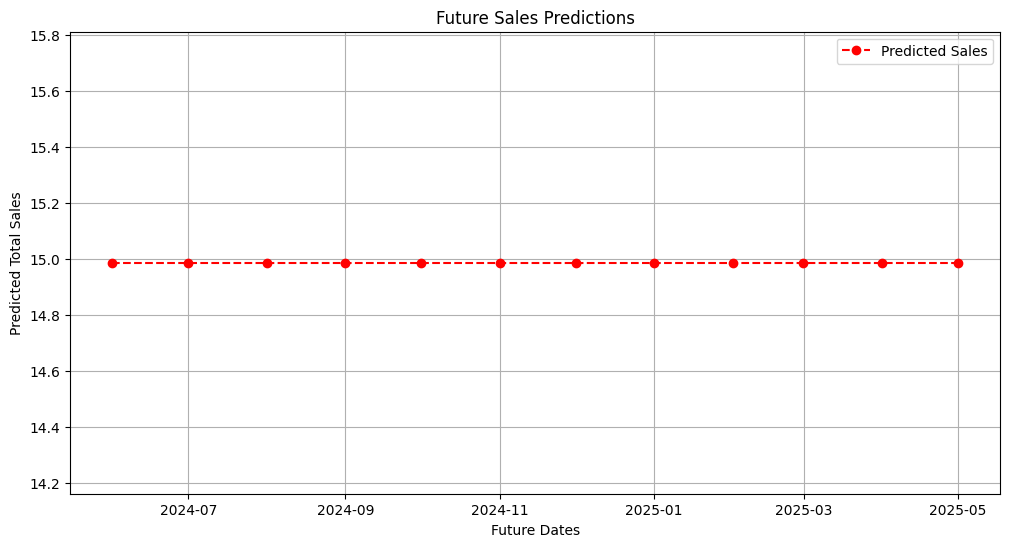

In [ ]:
#@title Predictive Insights
future_dates = pd.date_range(start=data['order_time'].max(), periods=12, freq='M')
future_data = pd.DataFrame({
    'pizza_size_encoded': [0]*12,
    'pizza_category_encoded': [0]*12
})

future_predictions = best_rf.predict(future_data)

plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='--', color='r', label='Predicted Sales')
plt.title('Future Sales Predictions')
plt.xlabel('Future Dates')
plt.ylabel('Predicted Total Sales')
plt.legend()
plt.grid(True)
plt.show()

# **Key Findings**

The distribution plot above shows the different data that reveal which pizza or categories are the most popular to the customers. Plus, there are key finding that customers frequently orders the medium sized pizza rather than the other sized presented on the dataset. These datas also presented the most picked ingredients. Also, pricing pattern accross different categories of pizza helps to understand the pricing strategy. By analysing this data we find out what are the top 10 common ingrients and the most pic sizes of pizza, we also gain comprehensive understanding of pizza sales, allowing us to fully understand the data-driven decision in order to understand on how to enhance the pizza business

# **Conclusion**

1. **The Popular Piza Sizes and Catergory**

- The data above indicates that certain pizza sizes are more popular among customers (medium). We can see base on the plot presented that the most pic size of pizza are medium - sized. This show the customer balance about the size and prices of the pizza.

2. **Top 10 Common Ingriedients**

- The montly sales trends show significant affect on the data presented, for example the top 10 most common pizza ingredients picked, indicates noticesable peaks during specific months. These peaks correlate on holidays, special events and promotional services. This may help to increase the overall sales.

In Conclusion

- The pizza sales will are based on the most sized picked and the top 10 common ingredients picked by customers. In addition, The analysis of pizza ingridients reveals significant peak on sales based on the customer most picked flavors. This reflects on customers preference and taste.


